In [64]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

import networkx as nx
import osmnx as ox
from libpysal import weights
import matplotlib.pyplot as plt
import momepy
from pydantic import UUID1
from shapely.geometry import Polygon, Point
from copy import deepcopy

In [65]:
DATA_PATH = Path(os.getcwd()).parent / "gjson_dataset"
DATA_PATH.exists()

True

In [66]:
PROJECTED_CRS = 32637
GEOGRAPHIC_CRS = 4326

In [67]:
def merge_transport_datasets(bus_df: gpd.GeoDataFrame, subway_df: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    subway_df["Type"] = "Subway"

    subway_df.rename(columns={"Text": "Name"}, inplace=True)

    subway_df = subway_df.drop(columns=["Number"])
    bus_df = bus_df.drop(columns=["TrStopId"])
    bus_df.rename(columns={"TrType": "Type"}, inplace=True)
    
    merged_df = pd.concat([bus_df, subway_df], ignore_index=True)
    merged_gdf = gpd.GeoDataFrame(merged_df, geometry="geometry")
    return merged_gdf

def get_street_json(version: int) -> str:
    file = DATA_PATH / f"Streets_{version}очередь.geojson"
    assert file.exists()
    return file

def get_house_json(version: int) -> str:
    file = DATA_PATH / f"House_{version}очередь_ЖК.geojson"
    assert file.exists()
    return file

def get_transport_points_gdf() -> gpd.GeoDataFrame:
    social_gdf = merge_transport_datasets(
        bus_df=gpd.read_file(DATA_PATH / 'Остановки_ОТ.geojson'),
        subway_df=gpd.read_file(DATA_PATH / 'Выходы_метро.geojson')
    )
    return social_gdf

In [68]:
transport_points = get_transport_points_gdf()
transport_points.fillna(value="subway", inplace=True)
print(transport_points.head(3))
residential_complex = gpd.read_file(get_house_json(1))
residential_complex.drop(['District', 'Street', 'Number'], axis=1, inplace=True)
print("\n", residential_complex.head(2))

                   Type                Name                   geometry
0  Автобусная остановка          д. Дудкино  POINT (37.45345 55.63557)
1  Автобусная остановка  Академика Семёнова  POINT (37.50908 55.54359)
2  Автобусная остановка     СНТ Гавриково-1  POINT (37.50263 55.54162)

          Type                Purpose  Elevation  Entrances  Apartments  \
0  Жилые дома  Малоэтажный жилой дом          3        4.0        86.0   
1  Жилые дома  Малоэтажный жилой дом          3        4.0        86.0   

                                            geometry  
0  POLYGON ((37.49657 55.54595, 37.49617 55.54561...  
1  POLYGON ((37.49447 55.54480, 37.49486 55.54488...  


In [69]:
transport_points

,Type,Name,geometry
0,Автобусная остановка,д. Дудкино,POINT (37.45345 55.63557)
1,Автобусная остановка,Академика Семёнова,POINT (37.50908 55.54359)
2,Автобусная остановка,СНТ Гавриково-1,POINT (37.50263 55.54162)
3,Автобусная остановка,СНТ Берёзка-Коммунарка-1,POINT (37.48954 55.55831)
4,Автобусная остановка,СНТ Берёзка-Коммунарка-1,POINT (37.48878 55.55945)
...,...,...,...
63,Subway,Потапово,POINT (37.49107 55.55184)
64,Subway,Потапово,POINT (37.49547 55.55201)
65,Subway,Потапово,POINT (37.49652 55.55206)
66,Subway,Потапово,POINT (37.49682 55.55360)


In [70]:
residential_complex

,Type,Purpose,Elevation,Entrances,Apartments,geometry
0,Жилые дома,Малоэтажный жилой дом,3,4.0,86.0,"POLYGON ((37.49657 55.54595, 37.49617 55.54561..."
1,Жилые дома,Малоэтажный жилой дом,3,4.0,86.0,"POLYGON ((37.49447 55.54480, 37.49486 55.54488..."
2,Жилые дома,Малоэтажный жилой дом,3,4.0,86.0,"POLYGON ((37.49575 55.54432, 37.49560 55.54415..."
3,Жилые дома,Малоэтажный жилой дом,3,4.0,86.0,"POLYGON ((37.49338 55.54538, 37.49336 55.54531..."
4,Жилые дома,Малоэтажный жилой дом,3,3.0,98.0,"POLYGON ((37.49718 55.54578, 37.49719 55.54568..."
5,Жилые дома,Малоэтажный жилой дом,3,4.0,66.0,"POLYGON ((37.49500 55.54561, 37.49511 55.54553..."
6,Жилые дома,Малоэтажный жилой дом,3,4.0,96.0,"POLYGON ((37.49388 55.54607, 37.49400 55.54537..."
7,Жилые дома,Малоэтажный жилой дом,3,4.0,86.0,"POLYGON ((37.49203 55.54591, 37.49177 55.54528..."
8,Жилые дома,Жилой дом,18,6.0,399.0,"MULTIPOLYGON (((37.48656 55.54479, 37.48610 55..."
9,Жилые дома,Жилой дом,18,6.0,382.0,"MULTIPOLYGON (((37.48523 55.54411, 37.48545 55..."


In [71]:
streets = gpd.read_file(get_street_json(0))  # Or toy sample gpd.read_file(momepy.datasets.get_path("bubenec"), layer="streets")
streets.crs  # This data is already in "4326"

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [72]:
from typing import Tuple

CropBox = Tuple[float, float, float, float]

def crop_gdf(gdf: gpd.GeoDataFrame, crop: CropBox) -> gpd.GeoDataFrame:
    x_min, y_max, x_max, y_min = crop
    crop_region = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])
    return gdf[gdf.geometry.within(crop_region)]

In [73]:
x_min, y_max = 37.472381, 55.549288
x_max, y_min = 37.490082, 55.539195

In [74]:
streets = crop_gdf(streets, (x_min, y_max, x_max, y_min))
transport_points = crop_gdf(transport_points, (x_min, y_max, x_max, y_min))
# house = crop_gdf(house, (x_min, y_max, x_max, y_min))

In [75]:
def plot_gpd(lines: gpd.GeoDataFrame = None, points: gpd.GeoDataFrame = None, polygons: gpd.GeoDataFrame = None, ax=None, show=False):
    if ax is None:
        show = True
        _, ax = plt.subplots(figsize=(8, 8))
        ax.set_title('Streets and Transport Stops')
        ax.legend(labels=['lines', 'points'])
    if lines is not None:
        lines.plot(ax=ax, color='gray', label='lines')
    if points is not None:
        points.plot(
            ax=ax,
            color='red',  # Choose a color that contrasts well with the streets
            marker='o',   # Use circle markers for points
            # markersize=50,
            label='points'
        )
    if polygons is not None:
        polygons.plot(
            ax=ax,
            color='orange',  # Choose a color that contrasts well with the streets
            marker='o',   # Use circle markers for points
            markersize=50,
            # label='polygons'
        )

    
    # ax.set_xlim([transport_points.total_bounds[0], transport_points.total_bounds[2]])
    # ax.set_ylim([transport_points.total_bounds[1], transport_points.total_bounds[3]])
    if show:
        plt.show()
    
def plot_graph(graph: nx.MultiGraph):
    fig, ax = plt.subplots(figsize=(8, 8))

    nx.draw(
        graph, {n: [n[0], n[1]] for n in list(graph.nodes)}, ax=ax, node_size=5
    )

    ax.set_title('Graph')

    plt.show()

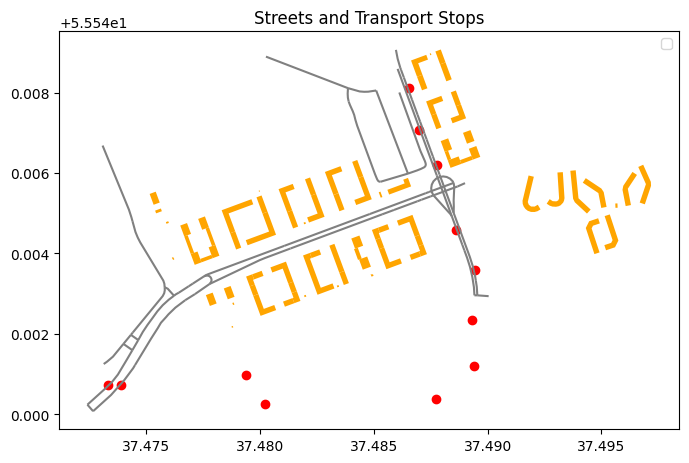

In [76]:
plot_gpd(streets, transport_points, residential_complex)

## Make projections on DataFrames 

In [77]:
projected_streets = streets.to_crs(epsg=PROJECTED_CRS)
projected_residence = residential_complex.to_crs(epsg=PROJECTED_CRS)
projected_transport_points = transport_points.to_crs(epsg=PROJECTED_CRS)

In [78]:
def get_graph(gdf: gpd.GeoDataFrame) -> nx.MultiGraph:
    gdf = gdf.iloc[:]
    if not gdf.crs.is_projected:
        print(f"DataFrame CRS is: {gdf.crs.srs} - not projected. Converting to {PROJECTED_CRS}...")
        gdf.to_crs(epsg=PROJECTED_CRS, inplace=True)
    return momepy.gdf_to_nx(gdf, approach="primal")

G = get_graph(streets)
G

DataFrame CRS is: EPSG:4326 - not projected. Converting to 32637...


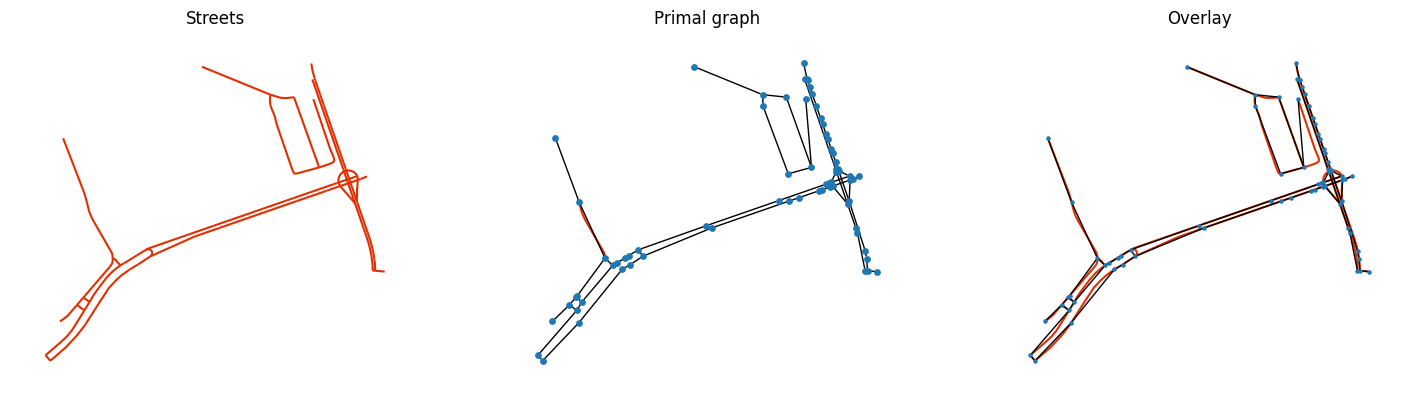

In [79]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
projected_streets.plot(color="#e32e00", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")
nx.draw(
    G, {n: [n[0], n[1]] for n in list(G.nodes)}, ax=ax[1], node_size=15
)
projected_streets.iloc[:1].plot(color="#e32e00", ax=ax[1], zorder=-1)  # Костыль, чтобы выровнять второй плот

projected_streets.plot(color="#e32e00", ax=ax[2], zorder=-1)
nx.draw(
    G, {n: [n[0], n[1]] for n in list(G.nodes)}, ax=ax[2], node_size=5
)

# Graph Analysis

## Connect houses and transport points to the Graph

In [92]:
def find_closest_node(point, graph):
    def euclidean_distance(node):
        x, y = node
        return np.sqrt(
                (x - point[0]) ** 2 + (y - point[1]) ** 2
        )
    return min(graph.nodes(), key=euclidean_distance)

In [93]:
from uuid import uuid4

In [94]:
def add_node(row: pd.Series, graph: nx.MultiGraph) -> None:
    centroid_point = (row["geometry"].centroid.x, row["geometry"].centroid.y)

    # Find the closest node in the street network
    closest_node = find_closest_node(centroid_point, G)

    # Add the building access point as a new node in the graph
    graph.add_node(centroid_point, NodeId=uuid4().int % 10 ** 8, **row.to_dict())
    print(f"added node: {centroid_point}")

    # Calculate the weight (distance) between the new node and the closest existing node
    weight = ((closest_node[0] - centroid_point[0]) ** 2 +
              (closest_node[1] - centroid_point[1]) ** 2) ** 0.5
    if weight:
        # Add an edge between the access point and the closest node in the street network
        graph.add_edge(centroid_point, closest_node, weight=weight, EdgeId=uuid4().int % 10 ** 8, )
        print(f"added edge with weight: {weight}")
    else:
        print(f"did not add edge due to zero weight")

## Before New nodes

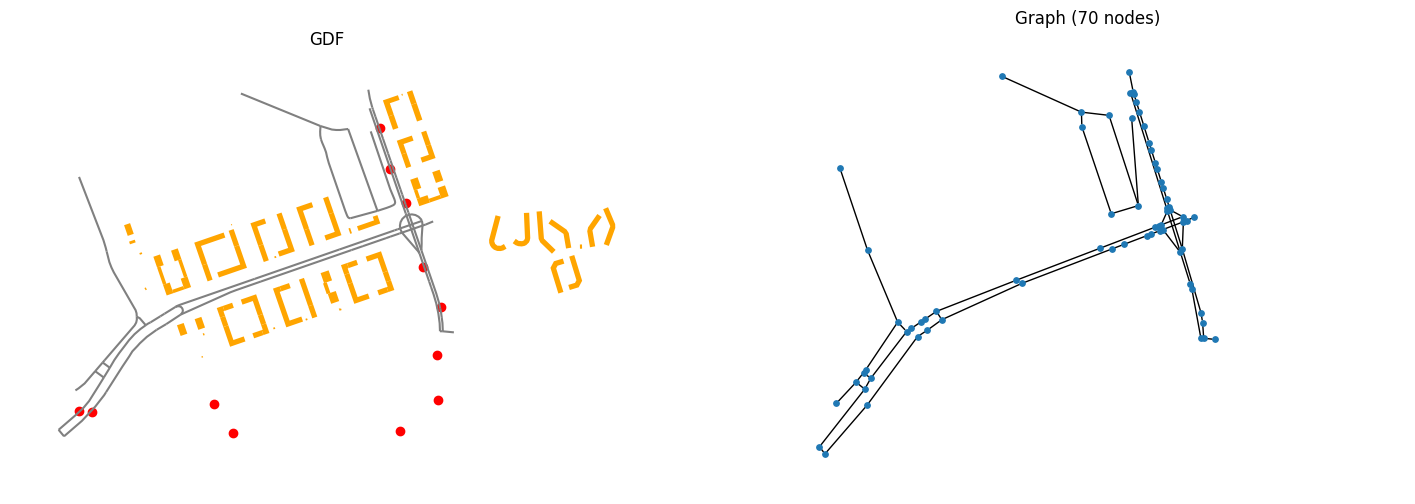

In [84]:
f, ax = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)

for i, facet in enumerate(ax):
    facet.set_title(("GDF", f"Graph ({len(G.nodes())} nodes)")[i])
    facet.axis("off")
nx.draw(
    G, {n: [n[0], n[1]] for n in list(G.nodes)}, ax=ax[1], node_size=15
)
plot_gpd(projected_streets, projected_transport_points, projected_residence, ax[0])

In [87]:
nodes_before = len(G.nodes)
print(f"Nodes before: {nodes_before}")
for idx, row in projected_residence.iterrows():
    add_node(row, G)
print(f"Residence Nodes added: {len(G.nodes) - nodes_before}")
for idx, row in projected_transport_points.iterrows():
    add_node(row, G)
print(f"Transport Nodes added: {len(G.nodes) - nodes_before}")

Nodes before: 73
added node: (405116.79988344066, 6156535.663966253)
added edge with weight: 453.14781619783236
added node: (405015.8365454626, 6156410.403777936)
added edge with weight: 160.88415208806788
added node: (405067.32616454887, 6156412.513966863)
added edge with weight: 51.532841673618975
added node: (404924.4626491559, 6156530.336331762)
added edge with weight: 150.77468750986952
added node: (405164.0870133059, 6156546.727891376)
added edge with weight: 48.564216147467036
added node: (405029.8800061175, 6156528.804172872)
added edge with weight: 87.1901476034506
added node: (404975.6193262176, 6156527.88223633)
added edge with weight: 51.21550734291496
added node: (404841.76109458704, 6156520.063021238)
added edge with weight: 83.33719480059763
added node: (404520.8632163564, 6156416.672345847)
added edge with weight: 92.88876104700867
added node: (404436.7561897739, 6156387.585816563)
added edge with weight: 88.99448357241204
added node: (404370.0681965028, 6156374.5873430

## With New nodes

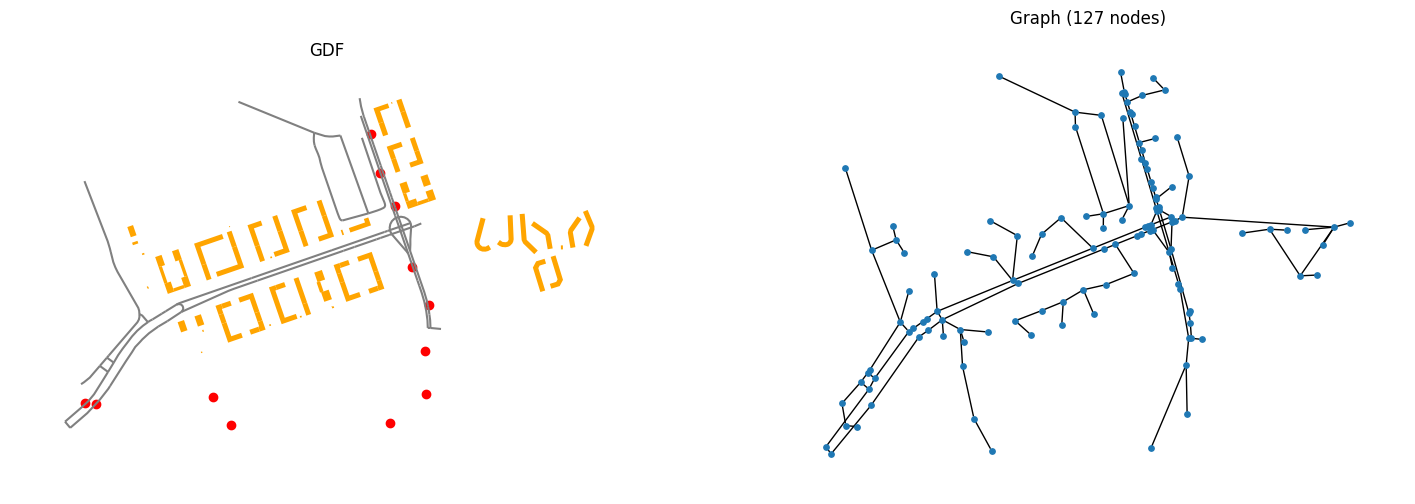

In [88]:
f, ax = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)

for i, facet in enumerate(ax):
    facet.set_title(("GDF", f"Graph ({len(G.nodes())} nodes)")[i])
    facet.axis("off")
nx.draw(
    G, {n: [n[0], n[1]] for n in list(G.nodes)}, ax=ax[1], node_size=15
)
plot_gpd(projected_streets, projected_transport_points, projected_residence, ax[0])

In [166]:
G

In [91]:
for node in G.nodes(data=True):
    print(node[-1])

{'x': 403824.7212574039, 'y': 6156291.3441104675}
{'x': 403739.4183769437, 'y': 6156476.162787694}
{'x': 404596.4897564013, 'y': 6156579.930598405}
{'x': 404631.04101927887, 'y': 6156479.49704017}
{'x': 404625.63185226126, 'y': 6156470.646783566}
{'x': 404653.15562031075, 'y': 6156390.642649359}
{'x': 404634.10279883235, 'y': 6156549.334546129}
{'x': 404658.36089556664, 'y': 6156375.518411114}
{'x': 404683.6906879967, 'y': 6156250.101994632}
{'x': 404691.73259467026, 'y': 6156249.893189216}
{'x': 404723.0941470638, 'y': 6156246.931140242}
{'x': 403733.6139266378, 'y': 6156167.954071499}
{'x': 404588.8672732458, 'y': 6156577.499549991}
{'x': 404576.06091242854, 'y': 6156529.425789045}
{'x': 403850.15095369256, 'y': 6156267.185404007}
{'x': 403748.2993283969, 'y': 6156146.7008777885}
{'x': 403603.20966041763, 'y': 6155970.867296828}
{'x': 403618.6213613649, 'y': 6155952.465739982}
{'x': 403737.6815636751, 'y': 6156077.390554419}
{'x': 404684.3728136473, 'y': 6156314.331008569}
{'x': 4037

In [90]:
for edge in G.edges(data=True):
    print(edge[-1])

{'EdgeId': 21069, 'ST_NAME': '', 'ST_TYP_BEF': '', 'ST_NM_BASE': '', 'ST_NM_CITY': '', 'FUNC_CLASS': 6, 'ROAD_CATEG': 'Внутриквартальные проезды', 'F_ZLEV': 0, 'T_ZLEV': 0, 'TYPE_LINK': 'Обычное звено', 'RoadDirect': 'Any', 'RbndStght': 1.0, 'RbndBck': 1.0, 'Width': 6.0, 'IsFerry': 'F', 'Style': 0, 'U_TURN': 3, 'OriginId': '4504316886929997', 'TrackNames': '', 'TopoNames1': '', 'MaxSpdDrct': 20, 'AvgSpdDrct': 20, 'MaxSpdRvrs': 20, 'AvgSpdRvrs': 20, 'Foot': 1, 'Car': 1, 'duplicat': '', 'payment': '', 'material': '', 'length': 205.403, 'geometry': <LINESTRING (403824.721 6156291.344, 403824.066 6156301.017, 403821.399 6156...>, 'mm_len': 205.34440293211392}
{'EdgeId': 28278657, 'ST_NAME': '', 'ST_TYP_BEF': '', 'ST_NM_BASE': '', 'ST_NM_CITY': '', 'FUNC_CLASS': 6, 'ROAD_CATEG': 'Внутриквартальные проезды', 'F_ZLEV': 0, 'T_ZLEV': 0, 'TYPE_LINK': 'Обычное звено', 'RoadDirect': 'Any', 'RbndStght': 1.0, 'RbndBck': 1.0, 'Width': 6.0, 'IsFerry': 'F', 'Style': 0, 'U_TURN': 3, 'OriginId': '4504316